# AMOC-FGCO2-MAPS

- This script extracts AMOC at 26N and North Atlantic regional air-sea CO2 fluxes
- There are two components of air-sea CO2 flux, contemporary and natural
- (Anthropogenic co2 flux) = (contempolary) - (natural)
- Extract regional patterns via regression/correlation analysis

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend
import cartopy.crs as ccrs
import netCDF4 as nc

# CESM2 analysis

In [2]:
# set file locations
dpr='/global/cfs/cdirs/m3920/dataset/cmip6/CESM2/'
# get MOC
ds=nc.Dataset(dpr+'/msftmz_Omon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc')
# get contemporary CO2 flux
df=xr.open_dataset(dpr+'/fgco2_CESM2_Omon_historical_r1i1p1f1_gn_woagrid.nc')
# get natural CO2 flux
df2=xr.open_dataset(dpr+'/fgco2nat_CESM2_Omon_historical_r1i1p1f1_gn_woagrid.nc')

## First quick look at the AMOC

- select the correct basin
- display the AMOC pattern so we can visually confirm

<class 'netCDF4._netCDF4.Variable'>
int32 basin(basin)
    coords: region
    requested: atlantic_arctic_ocean=0, indian_pacific_ocean=1, global_ocean=2
    standard_name: region
    title: ocean basin
    type: int
    units: 1
unlimited dimensions: 
current shape = (3,)
filling on, default _FillValue of -2147483647 used


/global/homes/t/takaito/miniconda3/envs/calc/lib/python3.8/site-packages/numpy/core/_methods.py:163: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  arr = asanyarray(a)


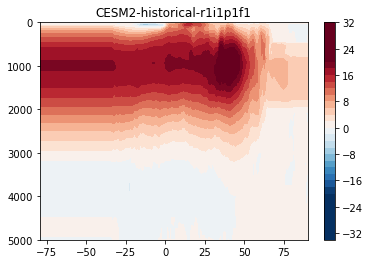

In [3]:
print(ds['basin'])
# Use basin = 0 to extract Atlantic
moc0=ds['msftmz']
moc1=np.mean(moc0,axis=0)*1e-6/1025#.mean(dim='time')
x=ds['lat'][:]
y=ds['lev'][:]*1e-2
#
moc=np.squeeze(moc1[0,:,:])
c=np.arange(-34,34,2)
plt.contourf(x,y,moc,c,cmap='RdBu_r',vmin=-20,vmax=20)
plt.ylim(5000,0)
plt.title('CESM2-historical-r1i1p1f1')
plt.colorbar()
wn='fig_amoc_cesm2_time_mean_185001-201412'
plt.savefig('fig/'+wn+'.pdf',bbox_inches="tight")
plt.show()

### Generate AMOC time series

- Apply FFT filters so we have monthly, annual and decadal time series

In [4]:
# get AMOC 26N time series
idx = (np.abs(x - 26)).argmin()
moc3=np.squeeze(moc0[:,0,:,idx])*1e-6/1025
amoc26N=np.max(moc3,axis=1)
time=np.arange('1850-01','2015-01',dtype='datetime64[M]')

/tmp/ipykernel_57257/1268733900.py:3: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  moc3=np.squeeze(moc0[:,0,:,idx])*1e-6/1025


In [5]:
# fft lowpass filter for decadal and longer component 
c=np.fft.fft(amoc26N)
freq=np.fft.fftfreq(np.size(amoc26N))
# calculate decadal component
ind=(np.abs(freq)>1/12)
c1=c
c1[ind]=0
amoc_IAV=np.fft.ifft(c1)
# calculate interannual component
ind=(np.abs(freq)>1/120)
c2=c
c2[ind]=0
amoc_DV=np.fft.ifft(c2)

/global/homes/t/takaito/miniconda3/envs/calc/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/global/homes/t/takaito/miniconda3/envs/calc/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


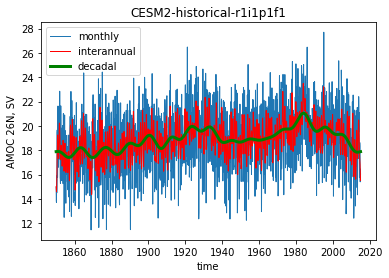

In [6]:
# Time series plot
plt.plot(time,amoc26N,label='monthly',zorder=10,linewidth=1)
plt.plot(time,amoc_IAV,'r-',label='interannual',linewidth=1,zorder=11)
plt.plot(time,amoc_DV,'g-',label='decadal',linewidth=3,zorder=12)
plt.xlabel('time')
plt.ylabel('AMOC 26N, SV')
plt.legend()
plt.title('CESM2-historical-r1i1p1f1')
wn='fig_amocts_cesm2'
plt.savefig('fig/'+wn+'.pdf',bbox_inches="tight")
plt.show()

## CO2 uptake
- North Atlantic CO2 uptake
- Drake spatial map of annual mean CO2 uptake
- Separate 2 components, anthropogenic and natural


In [7]:
fgco20 = df['fgco2']
fgco2nat=df2['fgco2nat']

In [8]:
# define North Atlantic domain
lat0 = 10   # Southern boundary
lon0 = -85  # Western boundary
lon1 = 10   # Eastern boundary

In [9]:
# Generate a time-average map
tave0 = fgco20.sel(time=slice('1990-01','2015-01')).mean(dim='time')
tave1 = fgco2nat.sel(time=slice('1990-01','2015-01')).mean(dim='time')
tave2 = tave0 - tave1
# conversion factor kg/m2/s -> mol/m2/yr
cfac = 1e3*1/12*86400*365
co2type=['contemporary','natural','anthro']
tave = np.stack((tave0,tave1,tave2))*cfac
da=xr.DataArray(data=tave,name='fgco2clim',dims=['comp','lat','lon'],
                coords={'comp':co2type,'lat':fgco20.lat,'lon':fgco20.lon})

/global/homes/t/takaito/miniconda3/envs/calc/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/global/homes/t/takaito/miniconda3/envs/calc/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/global/homes/t/takaito/miniconda3/envs/calc/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/global

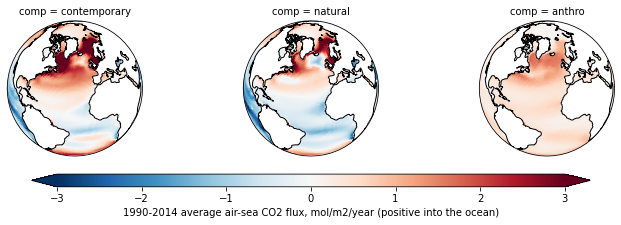

In [10]:
# set projection
map_proj = ccrs.Orthographic(-30, 35)
# plot
p=da.plot(col='comp',transform=ccrs.PlateCarree(), 
        vmin=-3,vmax=3, cmap='RdBu_r', 
        subplot_kws={"projection": map_proj},
        cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
        "label": '1990-2014 average air-sea CO2 flux, mol/m2/year (positive into the ocean)',
        },)
for ax in p.axes.flat:
    ax.coastlines()
plt.show()

## regression of CO2 flux onto AMOC 26N

In [11]:
# first, calculate CO2 flux anomaly (contemporary)
# conversion factor kg/m2/s -> mol/m2/yr
cfac = 1e3*1/12*86400*365
# select a time period
fgco2 = fgco20.sel(time=slice('1950-01','2015-12'))*cfac
# calculate monthly climatology
fgco2clim = fgco2.groupby('time.month').mean('time')
# calculate anomalies
fgco2a = fgco2.groupby('time.month')-fgco2clim

In [12]:
# next, calculate CO2 flux anomaly (natural)
# select a time period
fgco2 = fgco2nat.sel(time=slice('1950-01','2015-12'))*cfac
# calculate monthly climatology
fgco2clim = fgco2.groupby('time.month').mean('time')
# calculate anomalies
fgco2nata = fgco2.groupby('time.month')-fgco2clim

In [13]:
# next calculate AMOC anomaly
damoc= xr.DataArray(data=amoc26N,name='amoc',dims=['time'],coords={'time':time})  #alternatives are amoc_IAV and amoc_DV
amoc = damoc.sel(time=slice('1950-01','2015-12')) 
# calculate monthly climatology
amocclim = amoc.groupby('time.month').mean('time')
# calculate anomalies
amoca = amoc.groupby('time.month')-amocclim

In [14]:
# regression/correlation of CO2 flux onto AMOC 26N
#
# we get anthropogenic by difference
fgco2anta = fgco2a - fgco2nata
# get the data length
Nt=np.size(amoca)
#
# Calculation for contemporary CO2 flux
D=np.reshape(fgco2a.to_numpy(),(Nt,180*360),order='C')  # contemporary
Dnat=np.reshape(fgco2nata.to_numpy(),(Nt,180*360),order='C') # natural
Dant=np.reshape(fgco2anta.to_numpy(),(Nt,180*360),order='C') # anthro
#
X=np.reshape(amoca.to_numpy(),(Nt,1))
Dp=D-np.mean(D,axis=0) # contemporary
Dpnat=Dnat-np.mean(Dnat,axis=0) # natural
Dpant=Dant-np.mean(Dant,axis=0) # anthro
#
Xp=X-np.mean(X)
C=Dp.T@Xp/(Nt-1) # contemporary 
Cnat=Dpnat.T@Xp/(Nt-1) # natural
Cant=Dpant.T@Xp/(Nt-1) # anthro
#
Vx=np.var(X)
Vd=np.reshape(np.var(Dp,axis=0),(180*360,1)) # contemporary
Vdnat=np.reshape(np.var(Dpnat,axis=0),(180*360,1)) # natural
Vdant=np.reshape(np.var(Dpant,axis=0),(180*360,1)) # anthro
#
# regression coefficient # contemporary
Regr0=np.reshape(C/Vx,(180,360),order='C')
Corr0=np.reshape(C/np.sqrt(Vd)/np.sqrt(Vx),(180,360),order='C')
#
# regression coefficient # natural
Regr1=np.reshape(Cnat/Vx,(180,360),order='C')
Corr1=np.reshape(Cnat/np.sqrt(Vdnat)/np.sqrt(Vx),(180,360),order='C')
#
# regression coefficient # anthro
Regr2=np.reshape(Cant/Vx,(180,360),order='C')
Corr2=np.reshape(Cant/np.sqrt(Vdant)/np.sqrt(Vx),(180,360),order='C')
#

In [15]:
# combine the results into an xr.dataarray
tave = np.stack((Regr0,Regr1,Regr2))
dregr=xr.DataArray(data=tave,name='regr',dims=['comp','lat','lon'],
                coords={'comp':co2type,'lat':fgco20.lat,'lon':fgco20.lon})
#
tave = np.stack((Corr0,Corr1,Corr2))
dcorr=xr.DataArray(data=tave,name='corr',dims=['comp','lat','lon'],
                coords={'comp':co2type,'lat':fgco20.lat,'lon':fgco20.lon})

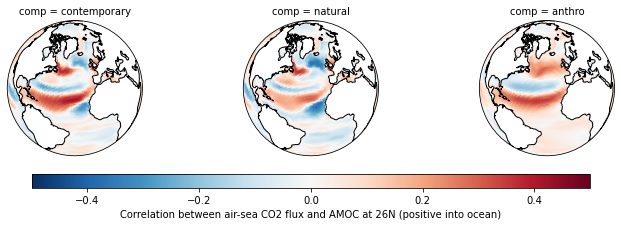

In [18]:
# set up the correlation map
# set projection
map_proj = ccrs.Orthographic(-30, 35)
# plot
p=dcorr.plot(col='comp',transform=ccrs.PlateCarree(), 
        vmin=-.5, cmap='RdBu_r', 
        subplot_kws={"projection": map_proj},
        cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
        "label": 'Correlation between air-sea CO2 flux and AMOC at 26N (positive into ocean)',
        },)
for ax in p.axes.flat:
    ax.coastlines()
plt.show()

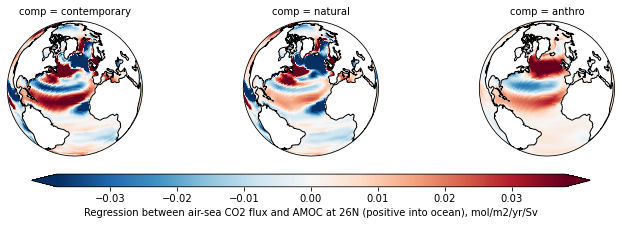

In [19]:
# set up the regression map
# set projection
map_proj = ccrs.Orthographic(-30, 35)
# plot
p=dregr.plot(col='comp',transform=ccrs.PlateCarree(), 
        robust=True, cmap='RdBu_r', 
        subplot_kws={"projection": map_proj},
        cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
        "label": 'Regression between air-sea CO2 flux and AMOC at 26N (positive into ocean), mol/m2/yr/Sv',
        },)
for ax in p.axes.flat:
    ax.coastlines()
plt.show()